**Table of contents**<a id='toc0_'></a>    
- [데이터 합치기](#toc1_1_)    
- [데이터 전처리](#toc2_)    
  - [sleep_startpoint_at_delta 컬럼 추가](#toc2_1_)    
  - [startpoint_at_delta, midpoint_at_delta 자정 전의 시간이면 음수를 갖도록 수정](#toc2_2_)    
  - [X 개인별 sleep_startpoint_at_delta, sleep_midpoint_at_delta 이상치 -> 중앙값으로 대체](#toc2_3_)    
- [Feature Engineering](#toc3_)    
  - [sleep_consistency 파생 변수 생성](#toc3_1_)    
    - [bedtime_start, midpoint_at_delta 컬럼 sin, cos 변환](#toc3_1_1_)    
    - [개인별 delta time sin, cos 벡터의 평균 길이 계산](#toc3_1_2_)    
    - [sleep_consistency](#toc3_1_3_)    
  - [필요없는 피처 제거](#toc3_2_)    
  - [데이터 스케일링](#toc3_3_)    
  - [데이터 나누기](#toc3_4_)    
- [SMOTE](#toc4_)    
- [모델 훈련 및 성능 검증](#toc5_)    
  - [test dataset 예측 결과](#toc5_1_)    
- [lightgbm 하이퍼 파라미터 최적화](#toc6_)    
  - [하이퍼파라미터 범위 설정](#toc6_1_)    
  - [베이지안 최적화용 평가지표 계산 함수](#toc6_2_)    
  - [최적화 수행](#toc6_3_)    
  - [최적화 결과 확인](#toc6_4_)    
- [lightgbm 모델 훈련 및 성능 검증](#toc7_)    
  - [test dataset 예측 결과](#toc7_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

train_path = "../../data/train/"
test_path = "../../data/validation/"

train_label = pd.read_csv(train_path + "label/1.걸음걸이/training_label.csv")
train = pd.read_csv(train_path + "raw/train_sleep.csv")

test_label = pd.read_csv(test_path + "label/1.걸음걸이/val_label.csv")
test = pd.read_csv(test_path + "raw/val_sleep.csv")

In [24]:
random_seed=42

In [6]:
label_encoder = {"CN": 0, "MCI": 1, "Dem": 2}

In [7]:
train_label["label"] = train_label["DIAG_NM"].map(label_encoder)
test_label["label"] = test_label["DIAG_NM"].map(label_encoder)
train_label.drop(columns=["DIAG_NM"], inplace=True)
test_label.drop(columns=["DIAG_NM"], inplace=True)

In [ ]:
# label 과 합치기
train = train.merge(train_label, left_on="EMAIL", right_on="SAMPLE_EMAIL")
test = test.merge(test_label, left_on="EMAIL", right_on="SAMPLE_EMAIL")

train.drop(columns=["SAMPLE_EMAIL"], inplace=True)
test.drop(columns=["SAMPLE_EMAIL"], inplace=True)

## <a id='toc1_1_'></a>[데이터 합치기](#toc0_)

In [9]:
all_data = pd.concat([train, test], axis=0)
all_data = all_data.drop(["label"], axis=1)  # 타겟값 제거

In [ ]:
all_data.columns

Index(['EMAIL', 'sleep_awake', 'sleep_bedtime_end', 'sleep_bedtime_start',
       'sleep_breath_average', 'sleep_deep', 'sleep_duration',
       'sleep_efficiency', 'sleep_hr_5min', 'sleep_hr_average',
       'sleep_hr_lowest', 'sleep_hypnogram_5min', 'sleep_is_longest',
       'sleep_light', 'sleep_midpoint_at_delta', 'sleep_midpoint_time',
       'sleep_onset_latency', 'sleep_period_id', 'sleep_rem', 'sleep_restless',
       'sleep_rmssd', 'sleep_rmssd_5min', 'sleep_score',
       'sleep_score_alignment', 'sleep_score_deep', 'sleep_score_disturbances',
       'sleep_score_efficiency', 'sleep_score_latency', 'sleep_score_rem',
       'sleep_score_total', 'sleep_temperature_delta',
       'sleep_temperature_deviation', 'sleep_total',
       'CONVERT(sleep_hr_5min USING utf8)',
       'CONVERT(sleep_hypnogram_5min USING utf8)',
       'CONVERT(sleep_rmssd_5min USING utf8)'],
      dtype='object')

# <a id='toc2_'></a>[데이터 전처리](#toc0_)

## <a id='toc2_1_'></a>[sleep_startpoint_at_delta 컬럼 추가](#toc0_)

In [ ]:
from datetime import datetime


# 자정과 timestamp의 차이(초)
def time_to_seconds_since_midnight(timestamp):
    dt = datetime.fromisoformat(timestamp[:-6])  # +09:00 타임존 offset 제거
    return dt.hour * 3600 + dt.minute * 60 + dt.second


all_data["sleep_startpoint_at_delta"] = all_data["sleep_bedtime_start"].apply(
    time_to_seconds_since_midnight
)

## <a id='toc2_2_'></a>[startpoint_at_delta, midpoint_at_delta 자정 전의 시간이면 음수를 갖도록 수정](#toc0_)

In [12]:
def adjust_delta_time(time):
    if time > 43200:
        time -= 86400
    return time


all_data["sleep_startpoint_at_delta"] = all_data["sleep_startpoint_at_delta"].apply(
    adjust_delta_time
)
all_data["sleep_midpoint_at_delta"] = all_data["sleep_midpoint_at_delta"].apply(
    adjust_delta_time
)

In [ ]:
all_data[["sleep_bedtime_start", "sleep_startpoint_at_delta"]]

,sleep_bedtime_start,sleep_startpoint_at_delta
0,2020-10-18T18:38:28+09:00,-19292
1,2020-10-19T21:39:52+09:00,-8408
2,2020-10-20T20:51:28+09:00,-11312
3,2020-10-21T22:08:16+09:00,-6704
4,2020-10-22T20:38:30+09:00,-12090
...,...,...
2473,2021-02-12T00:11:11+09:00,671
2474,2021-02-12T21:46:01+09:00,-8039
2475,2021-02-14T21:40:10+09:00,-8390
2476,2021-02-15T19:41:02+09:00,-15538


## <a id='toc2_3_'></a>[X 개인별 sleep_startpoint_at_delta, sleep_midpoint_at_delta 이상치 -> 중앙값으로 대체](#toc0_)

대체 안하는 것이 더 성능이 좋음

In [ ]:
# # IQR 기반 이상치 대체 함수
# def replace_outliers_with_median(group, columns):
#     for column in columns:
#         Q1 = group[column].quantile(0.25)
#         Q3 = group[column].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR

#         # 특이값을 중앙값으로 대체
#         group[column] = group[column].apply(
#             lambda x: group[column].median() if (x < lower_bound or x > upper_bound) else x
#         )
#     return group

# # 모든 사람에 대해 이상치 대체
# columns_to_replace = ["sleep_startpoint_at_delta", "sleep_midpoint_at_delta"]
# all_data = all_data.groupby("EMAIL", group_keys=False).apply(replace_outliers_with_median, columns_to_replace)

# <a id='toc3_'></a>[Feature Engineering](#toc0_)

## <a id='toc3_1_'></a>[sleep_consistency 파생 변수 생성](#toc0_)

### <a id='toc3_1_1_'></a>[bedtime_start, midpoint_at_delta 컬럼 sin, cos 변환](#toc0_)

In [ ]:
# 24시간 순환성을 가지도록
all_data["sleep_startpoint_at_delta_sin"] = np.sin(
    2 * np.pi * all_data["sleep_startpoint_at_delta"] / 86400
)
all_data["sleep_startpoint_at_delta_cos"] = np.cos(
    2 * np.pi * all_data["sleep_startpoint_at_delta"] / 86400
)

all_data["sleep_midpoint_at_delta_sin"] = np.sin(
    2 * np.pi * all_data["sleep_midpoint_at_delta"] / 86400
)
all_data["sleep_midpoint_at_delta_cos"] = np.cos(
    2 * np.pi * all_data["sleep_midpoint_at_delta"] / 86400
)

### <a id='toc3_1_2_'></a>[개인별 delta time sin, cos 벡터의 평균 길이 계산](#toc0_)
- 모든 벡터가 동일한 방향(즉, 같은 시간대)에 있으면 평균 벡터 길이 = 1
- 시간 차이가 많이날수록 두 벡터의 평균 길이는 짧아짐

<br><br>

- 완벽한 consistency -> MRL = 1
- 일정하지 않은 패턴 -> MRL < 1
- 완전히 랜덤한 패턴 -> MRL = 0

In [16]:
all_data["sleep_startpoint_at_delta_sin_cumsum"] = all_data.groupby("EMAIL")[
    "sleep_startpoint_at_delta_sin"
].cumsum()
all_data["sleep_startpoint_at_delta_cos_cumsum"] = all_data.groupby("EMAIL")[
    "sleep_startpoint_at_delta_cos"
].cumsum()
all_data["sleep_midpoint_at_delta_sin_cumsum"] = all_data.groupby("EMAIL")[
    "sleep_midpoint_at_delta_sin"
].cumsum()
all_data["sleep_midpoint_at_delta_cos_cumsum"] = all_data.groupby("EMAIL")[
    "sleep_midpoint_at_delta_cos"
].cumsum()
all_data["date_count"] = (
    all_data.groupby("EMAIL").cumcount() + 1
)  # cumcount 는 0부터 시작

In [ ]:
# mrl: mean resultant length: 벡터들 평균 길이
all_data["sleep_startpoint_at_delta_mrl"] = (
    np.sqrt(
        all_data["sleep_startpoint_at_delta_sin_cumsum"] ** 2
        + all_data["sleep_startpoint_at_delta_cos_cumsum"] ** 2
    )
    / all_data["date_count"]
)
all_data["sleep_midpoint_at_delta_mrl"] = (
    np.sqrt(
        all_data["sleep_midpoint_at_delta_sin_cumsum"] ** 2
        + all_data["sleep_midpoint_at_delta_cos_cumsum"] ** 2
    )
    / all_data["date_count"]
)

### <a id='toc3_1_3_'></a>[sleep_consistency](#toc0_)

In [ ]:
all_data["sleep_consistency"] = (
    all_data["sleep_startpoint_at_delta_mrl"] + all_data["sleep_midpoint_at_delta_mrl"]
) / 2

# 각 사용자(EMAIL)별 sleep_consistency의 중앙값(median) 계산
user_medians = all_data.groupby("EMAIL")["sleep_consistency"].median()

# 이전 3일간 수면 consistency의 변화(shift) 값의 NaN을 해당 사용자의 중앙값으로 채우기
for lag in range(1, 4):
    col_name = f"sleep_consistency_lag_{lag}"
    all_data[col_name] = all_data.groupby("EMAIL")["sleep_consistency"].shift(lag)
    all_data[col_name] = all_data[col_name].fillna(all_data["EMAIL"].map(user_medians))

# sleep_consistency의 3일 이동 평균
all_data["sleep_consistency_rolling_mean"] = all_data.groupby("EMAIL")[
    "sleep_consistency"
].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# 전날 값과 비교하여 변화량 계산
all_data["sleep_consistency_diff"] = all_data.groupby("EMAIL")[
    "sleep_consistency"
].diff()
all_data["sleep_consistency_diff"] = all_data["sleep_consistency_diff"].fillna(0)

## <a id='toc3_2_'></a>[필요없는 피처 제거](#toc0_)

In [19]:
drop_features = [
    "sleep_hr_5min",
    "sleep_rmssd_5min",
    "sleep_hypnogram_5min",
    "sleep_period_id",
    "sleep_is_longest",
    "EMAIL",
    "sleep_is_longest",
    "sleep_rmssd",
    "sleep_score",
    "sleep_score_alignment",
    "sleep_temperature_delta",
    "sleep_temperature_deviation",
    "sleep_startpoint_at_delta_mrl",
    "sleep_startpoint_at_delta",
    "sleep_midpoint_at_delta_mrl",
    "sleep_midpoint_at_delta",
    "sleep_startpoint_at_delta_sin_cumsum",
    "sleep_startpoint_at_delta_cos_cumsum",
    "sleep_midpoint_at_delta_sin_cumsum",
    "sleep_midpoint_at_delta_sin_cumsum",
    "sleep_startpoint_at_delta_sin",
    "sleep_startpoint_at_delta_cos",
    "sleep_midpoint_at_delta_sin",
    "sleep_midpoint_at_delta_sin",
]  # drop 확정

remaining_features = all_data.columns.difference(drop_features)

all_data = all_data[remaining_features]
all_data = all_data.select_dtypes(include=[int, float])  # 숫자형 데이터만
selected_features = all_data.columns

In [ ]:
selected_features

Index(['date_count', 'sleep_awake', 'sleep_breath_average',
       'sleep_consistency', 'sleep_consistency_diff',
       'sleep_consistency_lag_1', 'sleep_consistency_lag_2',
       'sleep_consistency_lag_3', 'sleep_consistency_rolling_mean',
       'sleep_deep', 'sleep_duration', 'sleep_efficiency', 'sleep_hr_average',
       'sleep_hr_lowest', 'sleep_light', 'sleep_midpoint_at_delta_cos',
       'sleep_midpoint_at_delta_cos_cumsum', 'sleep_midpoint_time',
       'sleep_onset_latency', 'sleep_rem', 'sleep_restless',
       'sleep_score_deep', 'sleep_score_disturbances',
       'sleep_score_efficiency', 'sleep_score_latency', 'sleep_score_rem',
       'sleep_score_total', 'sleep_total'],
      dtype='object')

## <a id='toc3_3_'></a>[데이터 스케일링](#toc0_)

In [ ]:
from sklearn.preprocessing import StandardScaler

all_data = StandardScaler().fit_transform(all_data)

## <a id='toc3_4_'></a>[데이터 나누기](#toc0_)

In [ ]:
num_train = len(train)

X = all_data[:num_train]
X_test = all_data[num_train:]

y = train["label"].values
y_test = test["label"].values

# <a id='toc4_'></a>[SMOTE](#toc0_)

Text(0, 0.5, 'Percentage (%)')

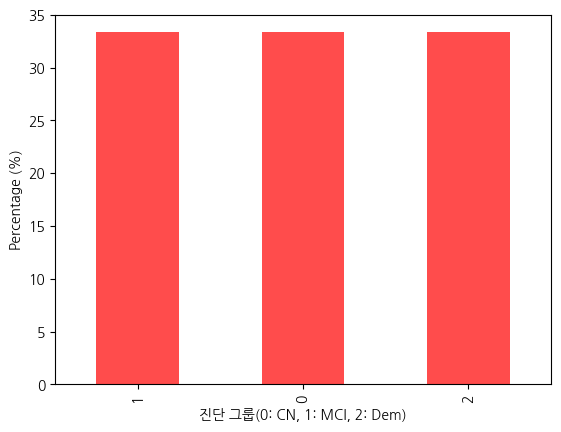

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=random_seed)
X_resampled, y_resampled = smote.fit_resample(X, y)

class_distribution_after = pd.Series(y_resampled).value_counts(normalize=True) * 100
class_distribution_after.plot(kind="bar", color="red", alpha=0.7)
plt.xlabel("진단 그룹(0: CN, 1: MCI, 2: Dem)")
plt.ylabel("Percentage (%)")

# <a id='toc5_'></a>[모델 훈련 및 성능 검증](#toc0_)

In [26]:
n_splits = 5

In [27]:
from sklearn.model_selection import StratifiedKFold

# shuffle: 훈련 데이터가 시계열 데이터가 아니라면 섞어주는 것이 좋음
# 시계열 데이터는 순서가 중요해서 데이터를 섞으면 안도미
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb

# 모델 학습 및 평가
models = {
    "Lasso Regression": LogisticRegression(
        penalty="l1", solver="liblinear", multi_class="ovr"
    ),
    "Decision Tree": DecisionTreeClassifier(random_state=random_seed),
    "Support Vector Machine": SVC(
        kernel="linear", probability=True, random_state=random_seed
    ),
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_seed),
    "LightGBM": lgb.LGBMClassifier(
        force_col_wise=True,  # force_col_wise param: warning 제거를 위한 추가
        callbacks=[
            lgb.early_stopping(100),
            lgb.log_evaluation(-1),
        ],
        random_state=random_seed,
    ),
}

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report
)

models_ = {}

for name, model in models.items():
    print("#" * 40, f"Model: {name}", "#" * 40)

    acc_scores = []
    f1_scores = []
    class_report_list = []

    for fold, (train_idx, val_idx) in enumerate(folds.split(X_resampled, y_resampled)):
        # 데이터 분할
        X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
        y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]

        # 모델 학습
        model.fit(X_train, y_train)

        # 모델 예측
        y_pred = model.predict(X_val)

        # 평가
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average="weighted")  # 불균형 데이터 고려
        acc_scores.append(acc)
        f1_scores.append(f1)

        # Classification Report 저장
        report = classification_report(y_val, y_pred, output_dict=True)
        class_report_list.append(pd.DataFrame(report).T)

    # Classification Report 평균
    avg_class_report = pd.concat(class_report_list).groupby(level=0).mean()

    # Model 저장
    models_[name] = model

    # Accuracy 및 F1-score 평균 출력
    print(f"=== Average Classification Report ===")
    print(avg_class_report)
    print(f"Average Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Average F1-score: {np.mean(f1_scores):.4f}")
    print("=" * 60)

######################################## Model: Lasso Regression ########################################
=== Average Classification Report ===
              precision    recall  f1-score      support
0              0.557501  0.483831  0.517877  1156.200000
1              0.557997  0.561497  0.559609  1156.200000
2              0.696768  0.783774  0.737642  1156.200000
accuracy       0.609699  0.609699  0.609699     0.609699
macro avg      0.604089  0.609701  0.605042  3468.600000
weighted avg   0.604089  0.609699  0.605042  3468.600000
Average Accuracy: 0.6097
Average F1-score: 0.6050
######################################## Model: Decision Tree ########################################
=== Average Classification Report ===
              precision    recall  f1-score      support
0              0.760940  0.717178  0.738316  1156.200000
1              0.741469  0.764055  0.752516  1156.200000
2              0.916307  0.940842  0.928400  1156.200000
accuracy       0.807357  0.807357  0.8

## <a id='toc5_1_'></a>[test dataset 예측 결과](#toc0_)

In [ ]:
# Test Set 성능 평가
print("\n", "=" * 40, "TEST SET EVALUATION", "=" * 40, "\n")

for name, model in models_.items():
    print(f"=== Evaluating {name} on Test Set ===")

    # 테스트 데이터 예측
    y_test_pred = model.predict(X_test)

    # 테스트 데이터 평가
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")  # 불균형 고려
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    # 결과 출력
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1-score: {test_f1:.4f}")
    print(f"Test Classification Report:\n", pd.DataFrame(test_report).T)
    print("=" * 60)


 ======================================== TEST SET EVALUATION ======================================== 

=== Evaluating Lasso Regression on Test Set ===
Test Accuracy: 0.4600
Test F1-score: 0.5244
Test Classification Report:
               precision    recall  f1-score      support
0              0.826206  0.464213  0.594435  1956.000000
1              0.129344  0.435065  0.199405   308.000000
2              0.285714  0.457944  0.351885   214.000000
accuracy       0.460048  0.460048  0.460048     0.460048
macro avg      0.413755  0.452407  0.381908  2478.000000
weighted avg   0.692913  0.460048  0.524389  2478.000000
=== Evaluating Decision Tree on Test Set ===
Test Accuracy: 0.5206
Test F1-score: 0.5744
Test Classification Report:
               precision    recall  f1-score      support
0              0.823918  0.574131  0.676710  1956.000000
1              0.146624  0.451299  0.221338   308.000000
2              0.167665  0.130841  0.146982   214.000000
accuracy       0.520581  0.5

# <a id='toc6_'></a>[lightgbm 하이퍼 파라미터 최적화](#toc0_)

## <a id='toc6_1_'></a>[하이퍼파라미터 범위 설정](#toc0_)

In [ ]:
param_bounds = {
    "num_leaves": (10, 56),
    "max_depth": (3, 15),
    "learning_rate": (0.01, 0.3),
    "lambda_l1": (0.0, 1.0),
    "lambda_l2": (0.0, 1.0),
    "feature_fraction": (0.5, 1.0),
    "bagging_fraction": (0.5, 1.0),
    "min_child_samples": (25, 50),
    "min_child_weight": (0.001, 10),
}

fixed_params = {
    "objective": "multiclass",
    "num_class": 3,
    "force_row_wise": True,
    "random_state": random_seed,
}

## <a id='toc6_2_'></a>[베이지안 최적화용 평가지표 계산 함수](#toc0_)

In [33]:
def recall_for_label_2(preds, data):
    """Dem(label=2)의 Recall을 계산하는 평가 함수"""
    y_true = data.get_label()  # 실제 정답 라벨
    y_pred = np.argmax(
        preds.reshape(len(y_true), -1), axis=1
    )  # 가장 높은 확률을 가진 클래스로 변환

    # label=2에 대한 Recall 계산
    recall = recall_score(y_true, y_pred, labels=[2], average="macro", zero_division=1)

    return "recall_label_2", recall, True  # True: 높은 값이 좋은 성능을 의미

In [ ]:
from sklearn.metrics import recall_score


# Dem(label=2)의 Recall을 기준으로 최적화
def lgb_eval(
    num_leaves,
    max_depth,
    learning_rate,
    lambda_l1,
    lambda_l2,
    feature_fraction,
    bagging_fraction,
    min_child_samples,
    min_child_weight,
):

    params = {
        "num_leaves": int(num_leaves),
        "max_depth": int(max_depth),
        "learning_rate": learning_rate,
        "lambda_l1": lambda_l1,
        "lambda_l2": lambda_l2,
        "feature_fraction": feature_fraction,
        "bagging_fraction": bagging_fraction,
        "min_child_samples": int(min_child_samples),
        "min_child_weight": min_child_weight,
    }

    params.update(fixed_params)

    print("하이퍼파라미터: ", params)

    # 교차 검증 (Stratified K-Fold, 5개 폴드)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    recall_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model = lgb.LGBMClassifier(
            **params,
            callbacks=[
                lgb.early_stopping(300),  # Early Stopping 콜백 적용
                lgb.log_evaluation(100),
            ]
        )  # 100 iteration마다 로그 출력 (-1로 비활성화 가능))
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])

        y_pred = model.predict(X_val)
        recall = recall_score(
            y_val, y_pred, labels=[2], average="macro", zero_division=1
        )
        recall_scores.append(recall)

    return np.mean(recall_scores)  # label=2의 Recall 평균 반환

## <a id='toc6_3_'></a>[최적화 수행](#toc0_)

In [35]:
from bayes_opt import BayesianOptimization

optimizer = BayesianOptimization(
    f=lgb_eval, pbounds=param_bounds, random_state=random_seed
)

In [ ]:
# 베이지안 최적화는 init_points + n_iter 만큼 반복
optimizer.maximize(init_points=5, n_iter=25)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
하이퍼파라미터:  {'num_leaves': 37, 'max_depth': 4, 'learning_rate': 0.055245405728306586, 'lambda_l1': 0.7319939418114051, 'lambda_l2': 0.5986584841970366, 'feature_fraction': 0.9753571532049581, 'bagging_fraction': 0.6872700594236812, 'min_child_samples': 26, 'min_child_weight': 8.661895281603577, 'objective': 'multiclass', 'num_class': 3, 'force_row_wise': True, 'random_state': 42}
[LightGBM] [Warning] at is set=, at= will be ignored. Current value: at=
[LightGBM] [Warning] object is set=, object= will be ignored. Current value: object=
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x1f2fc3d60>,<lightgbm.callback._LogEvaluationCallback
[LightGB

## <a id='toc6_4_'></a>[최적화 결과 확인](#toc0_)

In [37]:
max_params = optimizer.max["params"]
max_params

{'bagging_fraction': 1.0,
 'feature_fraction': 0.5,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'learning_rate': 0.3,
 'max_depth': 5.661768355094929,
 'min_child_samples': 37.252186193310145,
 'min_child_weight': 8.472319825037605,
 'num_leaves': 16.95579979221497}

In [38]:
# 정수형 하이퍼파라미터 변환
max_params["num_leaves"] = int(round(max_params["num_leaves"]))
max_params["min_child_samples"] = int(round(max_params["min_child_samples"]))
max_params["max_depth"] = int(round(max_params["max_depth"]))

In [ ]:
# 값이 고정된 하이퍼파라미터 추가
max_params.update(fixed_params)

# <a id='toc7_'></a>[lightgbm 모델 훈련 및 성능 검증](#toc0_)

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

acc_scores = []
f1_scores = []
class_report_list = []

for fold, (train_idx, val_idx) in enumerate(folds.split(X_resampled, y_resampled)):
    X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
    y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]

    model = lgb.LGBMClassifier(
        **max_params,
        callbacks=[
            lgb.early_stopping(300),  # Early Stopping 콜백 적용
            lgb.log_evaluation(100),
        ],
    )  # 100 iteration마다 로그 출력 (-1로 비활성화 가능))
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    # 평가
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average="weighted")  # 불균형 데이터 고려
    acc_scores.append(acc)
    f1_scores.append(f1)

    # Classification Report 저장
    report = classification_report(y_val, y_pred, output_dict=True)
    class_report_list.append(pd.DataFrame(report).T)

# Classification Report 평균
avg_class_report = pd.concat(class_report_list).groupby(level=0).mean()

# Accuracy 및 F1-score 평균 출력
print(f"=== Average Classification Report ===")
print(avg_class_report)
print(f"Average Accuracy: {np.mean(acc_scores):.4f}")
print(f"Average F1-score: {np.mean(f1_scores):.4f}")
print("=" * 60)

[LightGBM] [Warning] at is set=, at= will be ignored. Current value: at=
[LightGBM] [Warning] object is set=, object= will be ignored. Current value: object=
[LightGBM] [Warning] Unknown parameter: 0x1f2f2b370>
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] Unknown parameter: 0x1f2f2b820>,<lightgbm.callback._LogEvaluationCallback
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] at is set=, at= will be ignored. Current value: at=
[LightGBM] [Warning] object is se

## <a id='toc7_1_'></a>[test dataset 예측 결과](#toc0_)

In [41]:
# Test Set 성능 평가
print("\n", "=" * 40, "TEST SET EVALUATION", "=" * 40, "\n")

# 테스트 데이터 예측
y_test_pred = model.predict(X_test)

# 테스트 데이터 평가
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average="weighted")  # 불균형 고려
test_report = classification_report(y_test, y_test_pred, output_dict=True)

# 결과 출력
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print(f"Test Classification Report:\n", pd.DataFrame(test_report).T)
print("=" * 60)


 ======================================== TEST SET EVALUATION ======================================== 

[LightGBM] [Warning] at is set=, at= will be ignored. Current value: at=
[LightGBM] [Warning] object is set=, object= will be ignored. Current value: object=
[LightGBM] [Warning] Unknown parameter: object
[LightGBM] [Warning] Unknown parameter: 0x1f300dbe0>
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x1f300d4c0>,<lightgbm.callback._LogEvaluationCallback
[LightGBM] [Warning] Unknown parameter: callbacks
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
